# Mandelbrot Set - Mini Project - Stage 3

Numerical Scientific Computing (CE8-AVS) - Spring 2023 - Mini Project

**Author:** [Máté Tallósi](https://github.com/tallosim)
**Date:** 2023-04-26

In [1]:
import matplotlib.pyplot as plt
from dask import array as da
import numpy as np
import pyopencl as cl
import pandas as pd
import multiprocessing as mp
from numba import jit
import time
from tqdm import tqdm
import unittest

from utils import *

## Parameter Definition

The following parameters are used to define the Mandelbrot set. The parameters are defined in the following cell.

The resolution of the image is defined by the `X_RES` and `Y_RES` parameters. The `X_MIN`, `X_MAX`, `Y_MIN`, and `Y_MAX` parameters define the area of the complex plane that is displayed. The `I` parameter defines the maximum number of iterations for each pixel. The `T` parameter defines the threshold value for the Mandelbrot set.

In [2]:
X_RES = 5000
X_MIN = -2
X_MAX = 0.5
Y_RES = 5000
Y_MIN = -1.25
Y_MAX = 1.25

I = 50
T = 2

np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Madelbrot Set Ploting

In [3]:
def make_plot(M, 
              cmap='hot', 
              save=False, 
              filename='mandelbrot.png', 
              figsize=(8, 8), 
              extent=[X_MIN, X_MAX, Y_MIN, Y_MAX]):
    """
    Creates a plot of the Mandelbrot set from the input matrix M.

    Parameters:
    -----------
    M : numpy.ndarray
        The input matrix representing the Mandelbrot set.
    cmap : str or Colormap, optional
        The colormap used to plot the image. Defaults to 'hot'.
    save : bool, optional
        If True, saves the plot to a file with the given filename. Defaults to False.
    filename : str, optional
        The filename to save the plot to, if save is True. Defaults to 'mandelbrot.png'.
    figsize : tuple of int, optional
        The size of the figure to plot. Defaults to (10, 10).
    extent : list of float, optional
        The extent of the plot. Defaults to [X_MIN, X_MAX, Y_MIN, Y_MAX].

    Returns:
    --------
    None
    """
    
    plt.figure(figsize=figsize)
    plt.xlabel('Real axis')
    plt.ylabel('Imaginary axis')
    plt.imshow(M, cmap=cmap, aspect='equal', extent=extent)

    if save:
        plt.savefig(filename, dpi=600, bbox_inches='tight', pad_inches=0)

## Alreadey Implemented Calculation Methods

### Naive (loops) Implementation

In [4]:
def mandelbrot_naive(re, im, M, I, T):
    """
    Computes the Mandelbrot set using a naive algorithm.
    
    Parameters:
    -----------
    re : numpy.ndarray
        A one-dimensional array representing the real part of the complex plane.
    im : numpy.ndarray
        A one-dimensional array representing the imaginary part of the complex plane.
    M : numpy.ndarray
        A two-dimensional array used to store the output of the Mandelbrot set.
    I : int
        The maximum number of iterations used to compute the Mandelbrot set.
    T : int
        The threshold used to determine whether a complex number is in the Mandelbrot set.
        
    Raises:
    -------
    ValueError
        If the shape of C (`re`, `im`) and `M` do not match.

    Returns:
    --------
    None
    """
    
    if (im.shape[0], re.shape[0]) != M.shape:
        raise ValueError('C and M must have the same shape')
    
    x_max, y_max = M.shape
    
    for x in range(x_max):
        for y in range(y_max):
            c = re[y] + im[x] * 1j
            z = 0 + 0j
            for i in range(I):
                z = z**2 + c
                if T <= abs(z):
                    M[x, y] = i / I
                    break
            else:
                M[x, y] = 1

### Numpy (vectorized) Implementation

In [5]:
def mandelbrot_vectorized(re, im, M, I, T):
    """
    Computes the Mandelbrot set using a numpy vectorized algorithm.
    
    Parameters:
    -----------
    re : numpy.ndarray
        A one-dimensional array representing the real part of the complex plane.
    im : numpy.ndarray
        A one-dimensional array representing the imaginary part of the complex plane.
    M : numpy.ndarray
        A two-dimensional array used to store the output of the Mandelbrot set.
    I : int
        The maximum number of iterations used to compute the Mandelbrot set.
    T : int
        The threshold used to determine whether a complex number is in the Mandelbrot set.
        
    Raises:
    -------
    ValueError
        If the shape of C (`re`, `im`) and `M` do not match.

    Returns:
    --------
    None
    """
    
    if (im.shape[0], re.shape[0]) != M.shape:
        raise ValueError('C and M must have the same shape')
    
    c = re + im[:, np.newaxis] * 1j
    z = np.zeros_like(c)
    mask = np.full_like(c, True, dtype=bool)

    for i in range(1, I+1):
        z[mask] = z[mask]**2 + c[mask]
        mask[T <= np.abs(z)] = False
        M[mask] = i / I

### Numba (optimized) Implementation

In [6]:
@jit(nopython=True)
def mandelbrot_numba(re, im, M, I, T):
    """
    Computes the Mandelbrot set using Numba's just-in-time (JIT) compilation.
    
    Parameters:
    -----------
    re : numpy.ndarray
        A one-dimensional array representing the real part of the complex plane.
    im : numpy.ndarray
        A one-dimensional array representing the imaginary part of the complex plane.
    M : numpy.ndarray
        A two-dimensional array used to store the output of the Mandelbrot set.
    I : int
        The maximum number of iterations used to compute the Mandelbrot set.
    T : int
        The threshold used to determine whether a complex number is in the Mandelbrot set.
        
    Raises:
    -------
    ValueError
        If the shape of C (`re`, `im`) and `M` do not match.

    Returns:
    --------
    None
    """
    
    if (im.shape[0], re.shape[0]) != M.shape:
        raise ValueError('C and M must have the same shape')
    
    x_max, y_max = M.shape
    
    for x in range(x_max):
        for y in range(y_max):
            c = re[y] + im[x] * 1j
            z = 0 + 0j
            for i in range(I):
                z = z**2 + c
                if T <= abs(z):
                    M[x, y] = i / I
                    break
            else:
                M[x, y] = 1

### Parallel (using multiprocessing) Implementation

In [7]:
@jit(nopython=True)
def mandelbrot_chunk(re, im, I, T):
    """
    Computes the Mandelbrot set using Numba's just-in-time (JIT) compilation in one chunk.

    Parameters:
    -----------
    re : numpy.ndarray
        A one-dimensional array representing the real part of the complex plane.
    im : numpy.ndarray
        A one-dimensional array representing the imaginary part of the complex plane.
    I : int
        The maximum number of iterations used to compute the Mandelbrot set.
    T : int
        The threshold used to determine whether a complex number is in the Mandelbrot set.

    Returns:
    --------
    numpy.ndarray
        A two-dimensional array used to store the result of the computation.
    """

    M = np.zeros((im.shape[0], re.shape[0]))
    
    x_max, y_max = M.shape
    
    for x in range(x_max):
        for y in range(y_max):
            z = 0 + 0j
            for i in range(I):
                z = z**2 + re[y] + im[x] * 1j
                if abs(z) > T:
                    M[x, y] = i / I
                    break
            else:
                M[x, y] = 1
    
    return M

def mandelbrot_paralell(re, im, M, I, T, P=8, C=20):
    """
    Computes the Mandelbrot set using a parallel algorithm.

    Parameters:
    -----------
    re : numpy.ndarray
        A one-dimensional array representing the real part of the complex plane.
    im : numpy.ndarray
        A one-dimensional array representing the imaginary part of the complex plane.
    I : int
        The maximum number of iterations used to compute the Mandelbrot set.
    M : numpy.ndarray
        A two-dimensional array used to store the output of the Mandelbrot set.
    T : int
        The threshold used to determine whether a complex number is in the Mandelbrot set.
    P : int, optional
        The number of processes used for parallel computation. Defaults to 8.
    C : int, optional
        The chunk size used to divide the input arrays into subarrays. Defaults to 20.

    Raises:
    -------
    ValueError:
        If the shape of C (`re`, `im`) and `M` do not match.

    Returns:
    --------
    None
    """
    
    if (im.shape[0], re.shape[0]) != M.shape:
        raise ValueError('C and M must have the same shape')
    
    pool = mp.Pool(processes=P)

    results = [pool.apply_async(mandelbrot_chunk, args=(re[i:i+C], im, I, T)) for i in range(0, re.shape[0], C)]

    pool.close()
    pool.join()
    
    M[:] = np.hstack([r.get() for r in results])

### Dask (distributed) Implementation

In [8]:
def mandelbrot_dask(re, im, M, I, T):
    """
    Compute the Mandelbrot set using Dask for parallel computation.

    Parameters:
    -----------
    re : numpy.ndarray
        A one-dimensional array representing the real part of the complex plane.
    im : numpy.ndarray
        A one-dimensional array representing the imaginary part of the complex plane.
    M : np.ndarray
        A 2D array of floats to store the output of the computation.
    I : int
        The maximum number of iterations to use when computing the Mandelbrot set.
    T : float
        The threshold value for determining whether a point is part of the set.

    Raises:
    -------
    ValueError:
        If the shape of C (`re`, `im`) and `M` do not match.

    Returns:
    --------
    None
    """
    
    if (im.shape[0], re.shape[0]) != M.shape:
        raise ValueError('C and M must have the same shape')
    
    c = da.array(re + im[:, np.newaxis] * 1j)
    z = da.zeros_like(c)
    mask = da.full_like(c, True, dtype=bool)

    for i in range(1, I+1):
        z[mask] = z[mask]**2 + c[mask]
        mask[T <= da.abs(z)] = False
        M[mask] = i / I

## Unit Tests

Creating 3 unit tests to check the implemented mandelbrot set calculation methods.
- Test that the function raises a ValueError if the shape of the input arrays do not match
- Test that the output values are between 0 and 1.
- Test that the output values of the function are correct. The correctness is determined by an naive implementation of the Mandelbrot set.

In [9]:
class MandelbrotTest(unittest.TestCase):
    def setUp(self):
        self.x_res = 500
        self.y_res = 500
        self.mandelbrot_func = mandelbrot_vectorized
        self.accuracy = 5

    def test_parameters_value_errors(self):
        """
        Test that the function raises a ValueError if the shape of the input arrays do not match.
        """
        re = np.linspace(X_MIN, X_MAX, self.x_res)
        im = np.linspace(Y_MIN, Y_MAX,  self.y_res)
        M = np.zeros((self.x_res+1, self.y_res+1))
        
        with self.assertRaises(ValueError):
            self.mandelbrot_func(re, im, M, I, T)
        
    def test_output_values(self):
        """
        Test that the output values are between 0 and 1.
        """
        re = np.linspace(X_MIN, X_MAX, self.x_res)
        im = np.linspace(Y_MIN, Y_MAX, self.y_res)
        M = np.zeros((self.x_res, self.y_res))
        
        self.mandelbrot_func(re, im, M, I, T)
        
        self.assertTrue(np.all(M <= 1))
        self.assertTrue(np.all(M >= 0))
        
    def test_value_correctness(self):     
        """
        Test that the output values of the function are correct. The correctness is determined by an naive implementation of the Mandelbrot set.
        """   
        re = np.linspace(X_MIN, X_MAX, self.x_res)
        im = np.linspace(Y_MIN, Y_MAX, self.y_res)
        M = np.zeros((self.x_res, self.y_res))
        
        self.mandelbrot_func(re, im, M, I, T)
        
        for x in range(self.x_res):
            for y in range(self.y_res):
                c = re[y] + im[x] * 1j
                z = 0 + 0j
                for i in range(I):
                    z = z**2 + c
                    if abs(z) > T:
                        self.assertAlmostEqual(M[x, y], i / I, places=self.accuracy)
                        break
                else:
                    self.assertAlmostEqual(M[x, y], 1.0, places=self.accuracy)

In [10]:
print(f'Tested function: mandelbrot_vectorized')
unittest.main(argv=[''], verbosity=2, exit=False)   

test_output_values (__main__.MandelbrotTest)
Test that the output values are between 0 and 1. ... ok
test_parameters_value_errors (__main__.MandelbrotTest)
Test that the function raises a ValueError if the shape of the input arrays do not match. ... ok
test_value_correctness (__main__.MandelbrotTest)
Test that the output values of the function are correct. The correctness is determined by an naive implementation of the Mandelbrot set. ... 

Tested function: mandelbrot_vectorized


ok

----------------------------------------------------------------------
Ran 3 tests in 3.168s

OK


## OpenCL (GPU) Implementation

In [11]:
print_opencl_devices()
ctx = cl.create_some_context()

OpenCL Platforms and Devices
Platform - Name:  Apple
Platform - Vendor:  Apple
Platform - Version:  OpenCL 1.2 (Mar  4 2023 12:44:59)
Platform - Profile:  FULL_PROFILE
    --------------------------------------------------------
    Device - Name:  Apple M1
    Device - Type:  ALL | GPU
    Device - Max Clock Speed:  1000 Mhz
    Device - Compute Units:  8
    Device - Local Memory:  32 KB
    Device - Constant Memory:  1048576 KB
    Device - Global Memory: 11 GB
    Device - Max Buffer/Image Size: 2048 MB
    Device - Max Work Group Size: 256


### Implementation

The implementation of the OpenCl code is in the [`mandelbrot.cl`](mandelbrot.cl) file. The OpenCL code is compiled and the kernel is created in the following cell.

```c
__kernel void mandelbrot_kernel(__global float2 *c,
                                __global float *M,
                                const int I,
                                const float T) {
    // Get the global thread ID
    int gid = get_global_id(0);

    // Create a complex number
    float c_re = c[gid].x;
    float c_im = c[gid].y;

    // Create a complex number z
    float z_re = 0.0f;
    float z_im = 0.0f;

    // Initialize M to 0
    M[gid] = 0.0f;
    
    // Initialize stopped
    bool stopped = false;

    for (int i = 0; i < I; i++) {
        // Compute z = z^2 + c
        float z_re_new = z_re * z_re - z_im * z_im + c_re;
        float z_im_new = 2 * z_re * z_im + c_im;

        // Update z
        z_re = z_re_new;
        z_im = z_im_new;

        // If T <= |z|
        if (T * T <= z_re * z_re + z_im * z_im) {
            M[gid] = (float)i / (float)I;
            stopped = true;
            break;
        }
    }

    // If the point is in the Mandelbrot set, M[gid] = 0
    if (M[gid] == 0.0f && !stopped) {
        M[gid] = 1.0f;
    }
}
```

In [12]:
def mandelbrot_opencl(re, im, M, I, T, group_size=None):
    """
    Computes the Mandelbrot set using OpenCL.

    Parameters:
    -----------
    re : numpy.ndarray
        A one-dimensional array representing the real part of the complex plane.
    im : numpy.ndarray
        A one-dimensional array representing the imaginary part of the complex plane.
    M : np.ndarray
        A 2D array of floats to store the output of the computation.
    I : int
        The maximum number of iterations to use when computing the Mandelbrot set.
    T : float
        The threshold value for determining whether a point is part of the set.
    group_size : int or None
        The size of the workgroup used for parallel processing. Defaults to None.

    Raises:
    -------
    ValueError:
        If the shape of C (`re`, `im`) and `M` do not match.

    Returns:
    --------
    None
    """
    
    global ctx
    
    if (im.shape[0], re.shape[0]) != M.shape:
        raise ValueError('C and M must have the same shape')
    
    if group_size is not None:
        group_size = (group_size, group_size)

    queue = cl.CommandQueue(ctx)
    mf = cl.mem_flags
    
    c = re + im[:, np.newaxis] * 1j
    c_flat = np.ravel(c).astype(np.complex64)
    
    M_flat = np.ravel(M).astype(np.float32)
    
    c_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=c_flat)
    M_buf = cl.Buffer(ctx, mf.WRITE_ONLY, M_flat.nbytes)

    with open('mandelbrot.cl', 'r') as f:
        mandelbrot_kernel_source = f.read()
    
    prg = cl.Program(ctx, mandelbrot_kernel_source).build()
    prg.mandelbrot_kernel(queue, M_flat.shape, group_size, c_buf, M_buf, np.uint16(I), np.float32(T))

    cl.enqueue_copy(queue, M_flat, M_buf).wait()
    
    M[:] = M_flat.reshape(M.shape)

Time elapsed: 0.28 s


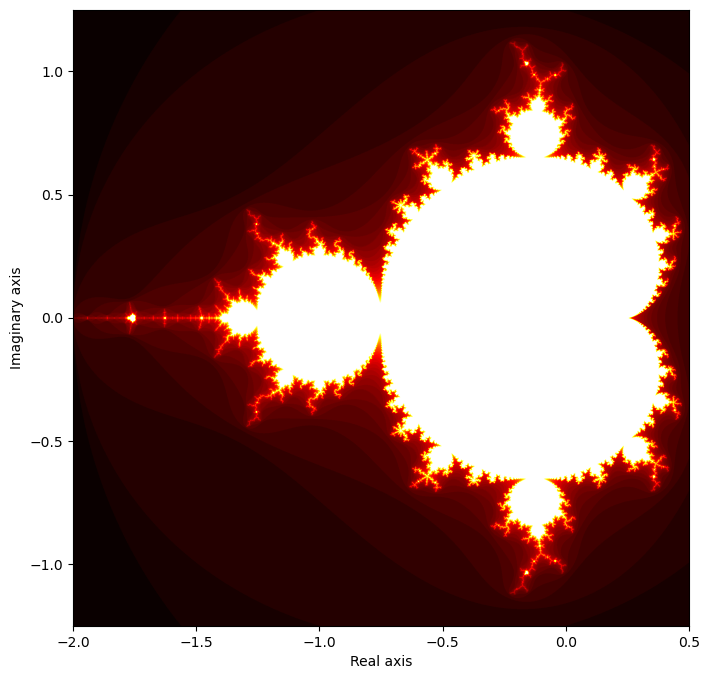

In [13]:
re = np.linspace(X_MIN, X_MAX, X_RES)
im = np.linspace(Y_MIN, Y_MAX, Y_RES)
M = np.zeros((X_RES, Y_RES))

time_start = time.time()
mandelbrot_opencl(re, im, M, I, T)
time_delta = time.time() - time_start

print(f'Time elapsed: {time_delta:.2f} s')
make_plot(M)

### Usage of different memory types

As you can see from the OpenCL kernel implementation, the `c` and `M` arrays are defined as global memory. The `c` array is read-only, and the `M` array is write-only. The `I` and `T` parameters are defined as constant memory, because they are not changed during the kernel execution. Besides the global and constant memory, the OpenCL kernel uses local memory as well. The local memory is used to store the `z` (`z_re`, `z_im`) and `c` (`c_re`, `c_im`) complex number. The `z` complex number is updated in each iteration of the Mandelbrot set calculation. The `z` and `c` complex number is not needed outside of the kernel, so it is stored in the local memory.

### Try different devices

I didn't have the chance to try different devices, because on the new Apple Silicon Macs, only the GPU is available for OpenCL as you can see the start of the start of the section. (for me at least)

### Comparsion of different group sizes

In [15]:
RES = 10000

group_sizes = [2**i for i in range(0, 14)]
calc_times = []

re = np.linspace(X_MIN, X_MAX, RES)
im = np.linspace(Y_MIN, Y_MAX, RES)

for group_size in tqdm(group_sizes):
    M = np.zeros((RES, RES))
    
    time_start = time.time()
    mandelbrot_opencl(re, im, M, I, T)
    time_delta = time.time() - time_start
    
    calc_times.append([group_size, time_delta])
    
calc_times_pd = pd.DataFrame(calc_times, columns=['group_size', 'time_delta'])
calc_times_pd.to_csv('mandelbrot-opencl-group-size-times.csv', index=False)
calc_times_pd

100%|██████████| 14/14 [00:16<00:00,  1.17s/it]


,group_size,time_delta
0,1,2.351427
1,2,1.489115
2,4,1.148100
3,8,1.062230
4,16,1.086454
5,32,1.012576
6,64,1.001151
7,128,0.997098
8,256,1.017503
9,512,1.062771


As you can see from the results, there is no significant difference between the different group sizes, only if the group size is 1 or 2, because in that case it's a little bit slower than the others.

### Comparsion of the different image resolutions

In [16]:
resolutions = [100, 200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
methods = [mandelbrot_paralell, mandelbrot_numba, mandelbrot_opencl]

calc_times = []

for resolution in tqdm(resolutions):
    for method in methods:
        re = np.linspace(X_MIN, X_MAX, resolution)
        im = np.linspace(Y_MIN, Y_MAX, resolution)
        M = np.zeros((resolution, resolution))
        
        time_start = time.time()
        method(re, im, M, I, T)
        time_delta = time.time() - time_start
        
        calc_times.append([resolution, method.__name__, time_delta])
        
calc_times_pd = pd.DataFrame(calc_times, columns=['resolution', 'method', 'time'])
calc_times_pd.to_csv('mandelbrot-numpy-numba-opencl-times.csv', index=False)

100%|██████████| 13/13 [01:38<00:00,  7.58s/it]


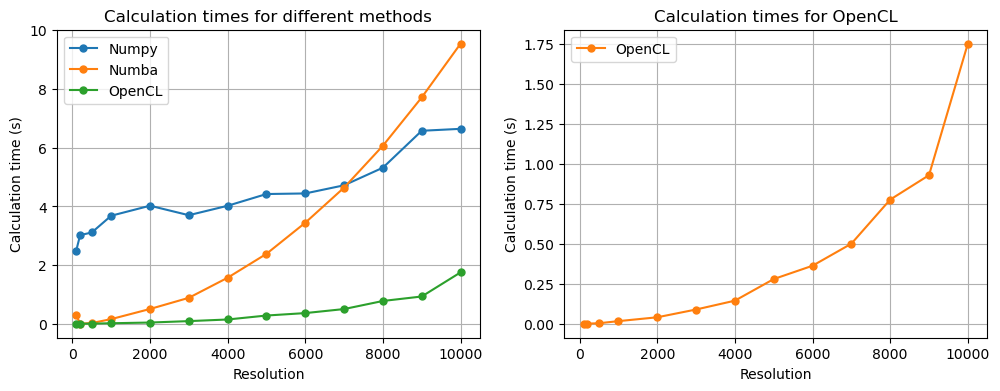

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for method in methods:
    axs[0].plot(calc_times_pd[calc_times_pd['method'] == method.__name__]['resolution'], 
             calc_times_pd[calc_times_pd['method'] == method.__name__]['time'], 
             label=method.__name__, marker='o', markersize=5)

axs[0].set_xlabel('Resolution')
axs[0].set_ylabel('Calculation time (s)')
axs[0].set_title('Calculation times for different methods')
axs[0].grid()
axs[0].legend(['Numpy', 'Numba', 'OpenCL'])

axs[1].plot(calc_times_pd[calc_times_pd['method'] == 'mandelbrot_opencl']['resolution'],
            calc_times_pd[calc_times_pd['method'] == 'mandelbrot_opencl']['time'],
            marker='o', markersize=5, c='tab:orange', label='OpenCL')

axs[1].set_xlabel('Resolution')
axs[1].set_ylabel('Calculation time (s)')
axs[1].set_title('Calculation times for OpenCL')
axs[1].grid()
axs[1].legend()

plt.show()

As you can see from the results, the OpenCL implementation is much faster, than the other implementations. The difference is even bigger, if the image resolution is higher.

## Extra: Optimization by mirroring

(only works if y_min = -y_max)

Time elapsed: 0.15 s


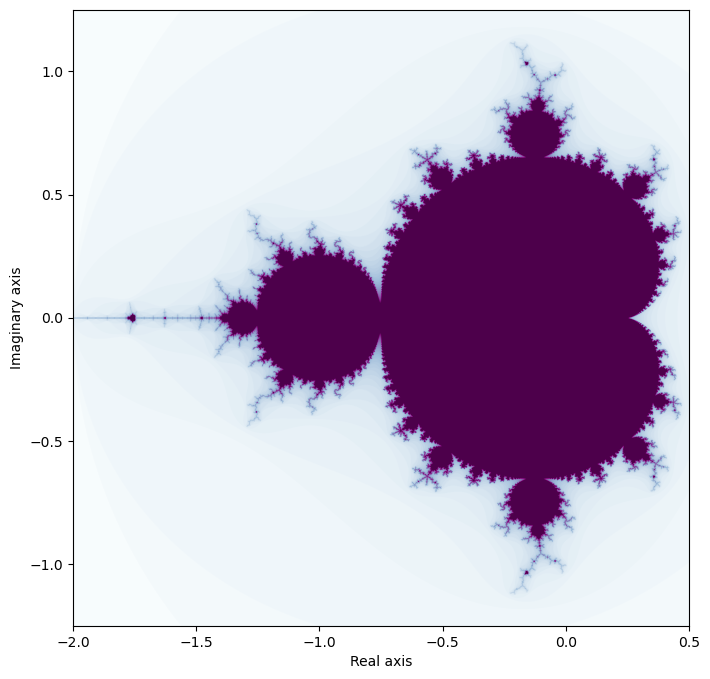

In [18]:
re = np.linspace(X_MIN, X_MAX, X_RES)
im = np.linspace(Y_MIN, 0, Y_RES // 2)
M_a = np.zeros((Y_RES // 2, X_RES))

time_start = time.time()
mandelbrot_opencl(re, im, M_a, I, T)
M_b = np.flipud(M_a)
M = np.vstack((M_a, M_b))
time_delta = time.time() - time_start

print(f'Time elapsed: {time_delta:.2f} s')
make_plot(M, cmap='BuPu')

As you can see from the results, the mirroring optimization is almost 2 times faster, than the original implementation (original: 0.28, mirrored: 0.15). However, the mirroring implementation gives a limitation to the y_min and y_max parameters, because they have to be the same value, but with different signs.

## Extra: Interesting Mandelbrot Coordinates and Color Mappings

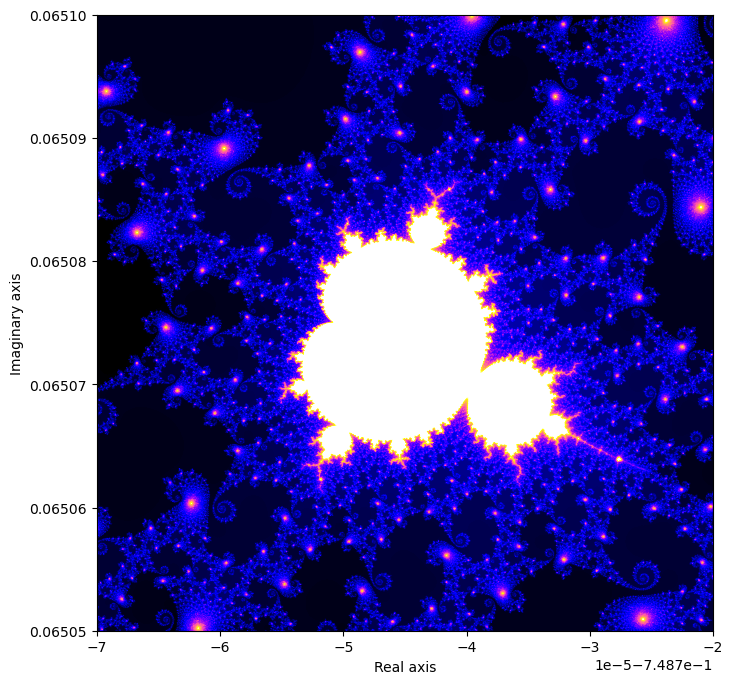

In [19]:
x_min, x_max = -0.74877, -0.74872
y_min, y_max = 0.06505, 0.06510

re = np.linspace(x_min, x_max, X_RES)
im = np.linspace(y_min, y_max, Y_RES)
M = np.zeros((X_RES, Y_RES))

mandelbrot_opencl(re, im, M, 2048, T)

make_plot(M, cmap='gnuplot2', extent=[x_min, x_max, y_min, y_max])

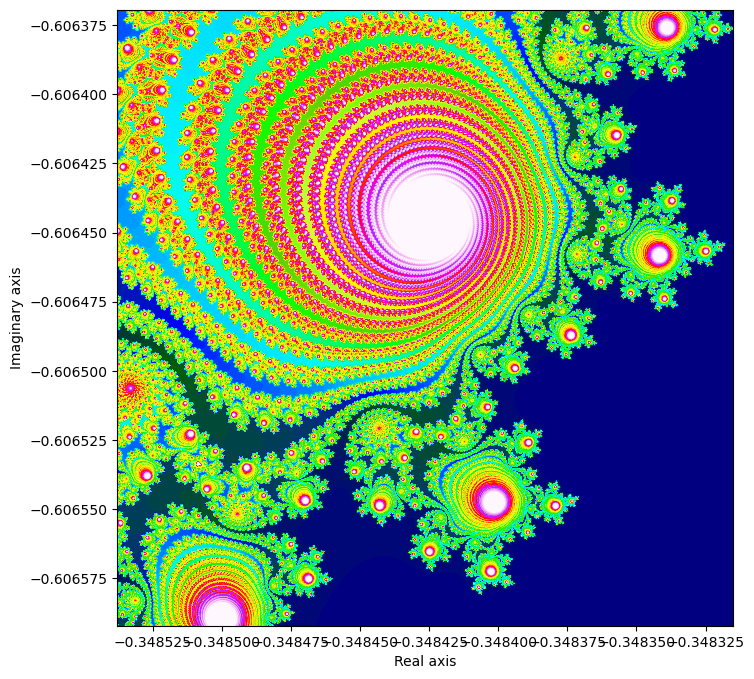

In [20]:
x_min, x_max = -0.34853774148008254, -0.34831493420245574
y_min, y_max = -0.6065922085831237, -0.6063694013054969

re = np.linspace(x_min, x_max, X_RES)
im = np.linspace(y_min, y_max, Y_RES)
M = np.zeros((X_RES, Y_RES))

mandelbrot_opencl(re, im, M, 2048, T)

make_plot(M, cmap='gist_ncar', extent=[x_min, x_max, y_min, y_max])

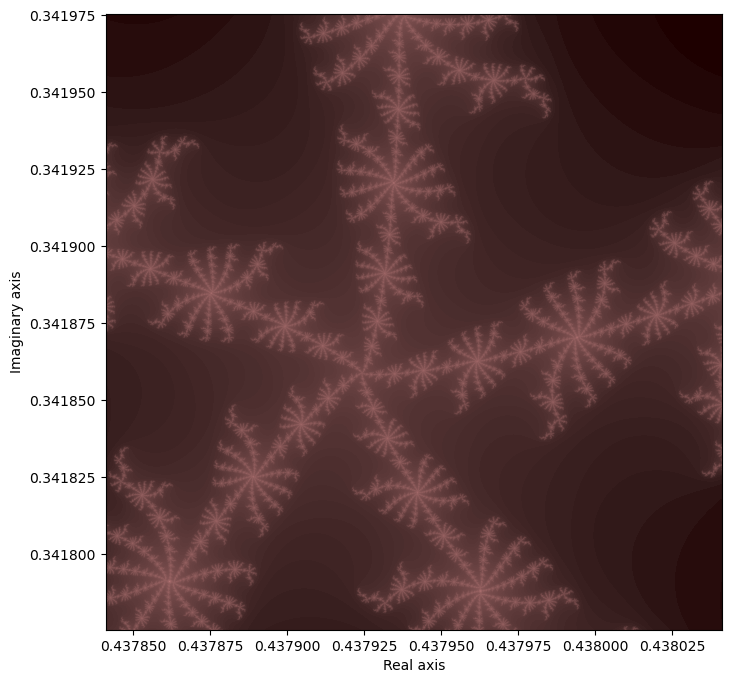

In [21]:
x_min, x_max = 0.437841098, 0.43804109799999996
y_min, y_max = 0.341775435, 0.341975435

re = np.linspace(x_min, x_max, X_RES)
im = np.linspace(y_min, y_max, Y_RES)
M = np.zeros((X_RES, Y_RES))

mandelbrot_opencl(re, im, M, 4092, T)

make_plot(np.log10(M), cmap='pink', extent=[x_min, x_max, y_min, y_max])

## Extra: Julia Set

In [22]:
@jit(nopython=True)
def julia_numba(re, im, M, I, T, c):
    if (im.shape[0], re.shape[0]) != M.shape:
        raise ValueError('C and M must have the same shape')
    
    x_max, y_max = M.shape
    
    for x in range(x_max):
        for y in range(y_max):
            z = re[x] + im[y] * 1j
            
            for i in range(I):
                z = z**2 + c
                
                if abs(z) > T:
                    M[x, y] = i / I
                    break
                
            else:
                M[x, y] = 1.0

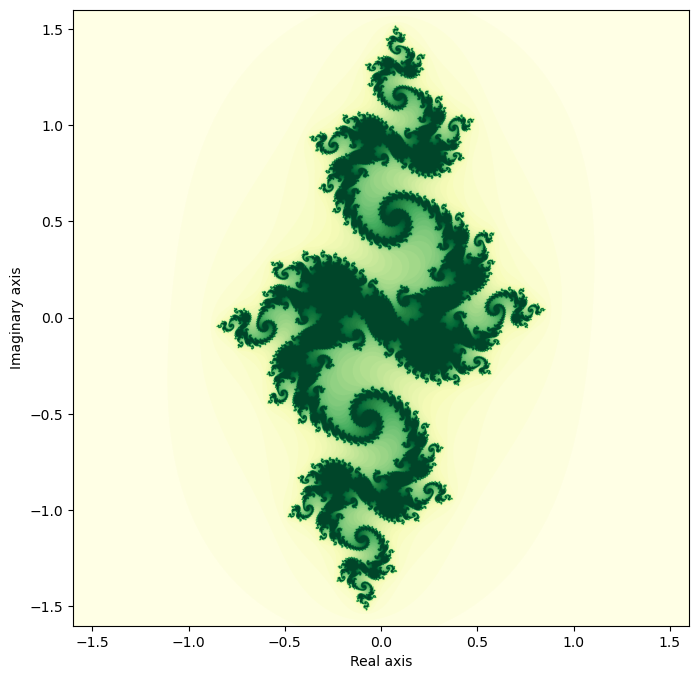

In [23]:
x_min, x_max = -1.6, 1.6
y_min, y_max = -1.6, 1.6

re = np.linspace(x_min, x_max, X_RES)
im = np.linspace(y_min, y_max, Y_RES)
M = np.zeros((X_RES, Y_RES))

c = -0.79 + 0.15j

julia_numba(re, im, M, I, T, c)

make_plot(M, cmap='YlGn', extent=[x_min, x_max, y_min, y_max])